In [1]:
import pandas as pd
import os
import glob
import re
from underthesea import text_normalize, word_tokenize

In [10]:
test_csv_path, train_csv_path = glob.glob(os.path.join('data', 'ViVQA-csv', '*.csv'))
df_test = pd.read_csv(test_csv_path).drop(['Unnamed: 0'], axis=1)
df_train = pd.read_csv(train_csv_path).drop(['Unnamed: 0'], axis=1)

df_total = pd.concat([df_test, df_train], axis=0)
df_total.drop_duplicates(subset=list(df_total.columns), inplace=True)
df_total.reset_index(drop=True, inplace=True)

df_total

,question,answer,img_id,type
0,màu của miếng vá là gì,màu xanh dương,557067,2
1,màu của áo là gì,màu cam,436394,2
2,màu của áo là gì,màu xanh dương,541050,2
3,màu của căn phòng là gì,màu trắng,426077,2
4,màu của quả bóng là gì,màu đỏ,314710,2
...,...,...,...,...
14839,có bao nhiêu người cố gắng chặn người khác đan...,một,492171,1
14840,có bao nhiêu phụ nữ đang tạo dáng chụp ảnh tro...,hai,196378,1
14841,có bao nhiêu thanh niên đối đầu với nhau trong...,hai,524063,1
14842,có bao nhiêu cái bánh mì kẹp xúc xích đang ngồ...,hai,72955,1


In [11]:
df_total.to_csv('dataset.csv', index=False)

In [2]:
df = pd.read_csv('data/dataset.csv')
df.head()

,question,answer,img_id,type
0,màu của miếng vá là gì,màu xanh dương,557067,2
1,màu của áo là gì,màu cam,436394,2
2,màu của áo là gì,màu xanh dương,541050,2
3,màu của căn phòng là gì,màu trắng,426077,2
4,màu của quả bóng là gì,màu đỏ,314710,2


In [4]:
period_strip = re.compile(r'(?!<=\d)(\.)(?!\d)')
comma_strip = re.compile(r'(\d)(,)(\d)')
punctuation_chars = re.escape(r';/[]"{}()=+\_-><@`,?!.')
punctuation = re.compile(r'([{}])'.format(re.escape(punctuation_chars)))
punctuation_with_a_space = re.compile(r'(?<= )([{0}])|([{0}])(?= )'.format(punctuation_chars))

def process_punctuation(s):
    if punctuation.search(s) is None:
        return s
    s = punctuation_with_a_space.sub('', s)
    if re.search(comma_strip, s) is not None:
        s = s.replace(',', '')
    s = punctuation.sub(' ', s)
    s = period_strip.sub('', s)
    return s.strip()

In [5]:
from collections import Counter

def preprocess_questions(df):
    questions = [question.lower() for question in list(df['question'])]
    return questions

def preprocess_answers(df):
    answers = [process_punctuation(answer.lower()) for answer in list(df['answer'])]
    return answers


def extract_vocab(questions, answers):
    words = [word for question in questions for word in word_tokenize(question)]
    words = Counter(words).most_common()
    answers = Counter(answers).most_common()
    vocab_q = {word : i+1 for i, (word,_) in enumerate(words)}
    vocab_a = {answer: i for i, (answer,_) in enumerate(answers)}
    return vocab_q, vocab_a


questions = preprocess_questions(df)
answers = preprocess_answers(df)

vocab_q, vocab_a = extract_vocab(questions, answers)

In [7]:
for question in questions:
    print(question)

màu của miếng vá là gì
màu của áo là gì
màu của áo là gì
màu của căn phòng là gì
màu của quả bóng là gì
màu của con ngựa là gì
màu của tòa nhà là gì
màu của thập giá là gì
màu của điện thoại là gì
màu của xe máy là gì
màu của chiếc đĩa là gì
màu của vòi nước là gì
màu của áo là gì
màu của xe buýt là gì
màu của túi là gì
màu của khăn là gì
màu của bầu trời là gì
màu của con ngựa là gì
màu sắc của máy bay phản lực là gì
màu của một nửa là gì
màu của quầy là gì
màu của gấu là gì
màu của chiếc bình là gì
màu của quả bóng là gì
màu của xe máy là gì
màu của xe là gì
màu của bảng là gì
màu của áo là gì
màu của xe buýt là gì
màu của chiếc đĩa là gì
màu của bồn rửa mặt là gì
màu của áo là gì
màu của xe buýt là gì
màu của con mèo là gì
màu của cà vạt là gì
màu của áo là gì
màu của xe là gì
màu của chiếc tàu là gì
màu sắc của icing là gì
màu của chiếc ô là gì
màu sắc của hành tây là gì
màu của chiếc đĩa là gì
màu của bồn là gì
màu của quầy là gì
màu sắc của người trồng là gì
màu mắt là gì
màu của

In [5]:
import numpy as np
import torch
import torch.nn as nn

global x

def max_question_len(questions):
    return max([len(word_tokenize(question)) for question in questions])

def idx2word(vocab_dict):
    return {str(i): vocab for i, vocab in enumerate(vocab_dict)}

def questions_embedding(questions, vocab_q, embeding_dim):
    max_len = max_question_len(questions)
    vecs = []
    embedding = nn.Embedding(num_embeddings=len(vocab_q)+1, embedding_dim=embeding_dim, padding_idx=0)
    for question in questions:
        words = word_tokenize(question)
        vec = torch.zeros(max_len, dtype=torch.long)
        for i, word in enumerate(words):
            idx = vocab_q.get(word, 0)
            vec[i] = idx
        vecs.append(embedding(vec))
    return vecs

def encode_answers(answers, vocab_a):
    max_len = len(vocab_a)
    vecs = []
    for answer in answers:
        vec = torch.zeros(max_len)
        idx = vocab_a.get(answer)
        if idx is not None:
            vec[idx] = 1
            vecs.append(vec)
            continue

c:\Users\ngocs\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([26, 10])

In [30]:
class VocabDictionary:
    def __init__(self, ):
        pass

'bàn chải đánh răng .'

In [82]:
from torch.utils.data import Dataset
from utils import config
from utils import preprocess_questions, preprocess_answers
import json

class ViVQADataset(Dataset):
    def __init__(self, df):
        with open(config.__VOCAB__, 'r') as f:
            vocab = json.loads(f.read())
        
        self.vocab_q = vocab['question']
        self.vocab_a = vocab['answers']

        # q and a
        self.questions = self.encode_questions(preprocess_questions(df), self.vocab_q)
        self.answers = self.encode_answers(preprocess_answers(df), self.vocab_a)
        
        # v
        


    def encode_questions(self, questions, vocab_q):
        max_len = max_question_len(questions)
        vecs = []
        for question in questions:
            words = word_tokenize(question)
            vec = torch.zeros(max_len, dtype=torch.long)
            for i, word in enumerate(words):
                idx = vocab_q.get(word, 0)
                vec[i] = idx
            vecs.append(vec)
        return vecs
    
    def encode_answers(self, answers, vocab_a):
        max_len = len(vocab_a)
        vecs = []
        for answer in answers:
            vec = torch.zeros(max_len)
            idx = vocab_a.get(answer)
            if idx is not None:
                vec[idx] = 1
                vecs.append(vec)
                continue
        return vecs

ImportError: cannot import name 'preprocess_questions' from 'utils' (unknown location)

In [9]:
from torchvision.models import resnet152
import torch
from utils import config
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import glob
import numpy as np

def get_transforms(target_size, central_fraction=1.0):
    return transforms.Compose([
        transforms.Resize(int(target_size / central_fraction)),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

class ViQAImages(Dataset):
    def __init__(self, path, transform=None):
        super(ViQAImages, self).__init__()
        self.path = path
        self.id2filename = self.generate_id2filename()
        self.ids = list(self.id2filename.keys())
        self.transform = transform

    def generate_id2filename(self):
        d = {}
        file_paths = sorted(glob.glob(os.path.join(self.path, '*.jpg')))
        for file_path in file_paths:
            file_name = os.path.basename(file_path)
            id = file_name.split('.')[0]
            d[id] = file_name
        return d
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        id = self.ids[idx]
        file_name = self.id2filename[id]
        img = Image.open(os.path.join(self.path, file_name)).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return id, img


obj = ViQAImages(path='data/images')
id, img = obj[0]
print(type(img))

<class 'PIL.Image.Image'>


In [6]:
np.array(Image.fromarray(img))

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  4,   0,   0],
        [  4,   0,   0],
        [  7,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  4,   0,   0],
        [  6,   0,   0],
        [ 11,   2,   3]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  5,   0,   1],
        [  7,   1,   3],
        [ 12,   3,   6]],

       ...,

       [[ 15,  48,  83],
        [ 15,  48,  83],
        [ 15,  48,  83],
        ...,
        [ 65,  93, 130],
        [ 64,  93, 127],
        [ 65,  93, 130]],

       [[ 15,  48,  83],
        [ 15,  48,  83],
        [ 15,  48,  83],
        ...,
        [ 39,  68, 102],
        [ 38,  67,  99],
        [ 38,  67, 101]],

       [[ 15,  48,  83],
        [ 15,  48,  83],
        [ 15,  48,  83],
        ...,
        [ 23,  52,  84],
        [ 22,  51,  83],
        [ 22,  51,  83]]

In [2]:
type(img)

PIL.Image.Image

In [27]:
import torch
def tile(question_features, visual_features):
    batch_size, num_features = question_features.size()

    spatial_size = visual_features.dim() - 2
    tiled = question_features.view(batch_size, num_features, *([1]*spatial_size))
    return tiled

x = torch.tensor([[1,2,3,4]])
y = torch.zeros((1,7, 8, 8))
tile(x,y).size()

torch.Size([1, 4, 1, 1])

In [32]:
import torch

def tile(question_features, visual_features):
    batch_size, num_features = question_features.size()
    _, _, height, width = visual_features.size()
    
    spatial_size = visual_features.dim() - 2
    tiled = question_features.view(batch_size, num_features, *([1]*spatial_size)).expand(batch_size, num_features, height, width)
    
    return tiled

x = torch.tensor([[1, 2, 3, 4]])
y = torch.zeros((1, 7, 8, 8))
result = tile(x, y)
result


tensor([[[[1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1]],

         [[2, 2, 2, 2, 2, 2, 2, 2],
          [2, 2, 2, 2, 2, 2, 2, 2],
          [2, 2, 2, 2, 2, 2, 2, 2],
          [2, 2, 2, 2, 2, 2, 2, 2],
          [2, 2, 2, 2, 2, 2, 2, 2],
          [2, 2, 2, 2, 2, 2, 2, 2],
          [2, 2, 2, 2, 2, 2, 2, 2],
          [2, 2, 2, 2, 2, 2, 2, 2]],

         [[3, 3, 3, 3, 3, 3, 3, 3],
          [3, 3, 3, 3, 3, 3, 3, 3],
          [3, 3, 3, 3, 3, 3, 3, 3],
          [3, 3, 3, 3, 3, 3, 3, 3],
          [3, 3, 3, 3, 3, 3, 3, 3],
          [3, 3, 3, 3, 3, 3, 3, 3],
          [3, 3, 3, 3, 3, 3, 3, 3],
          [3, 3, 3, 3, 3, 3, 3, 3]],

         [[4, 4, 4, 4, 4, 4, 4, 4],
          [4, 4, 4, 4, 4, 4, 4, 4],
          [4, 4, 4, 4, 4, 4, 4, 4],
          [4, 4, 4, 4,

In [62]:
import numpy as np
x = np.array([[[1,2,3,4],
            [5,6,7,8],
            [9,10,11,12],
]])

y = np.array([
    [[13,14,15,16]],
    [[17,18,19,20]]
])

z = x * y
np.sum((np.expand_dims(x, axis=(0,)) * np.expand_dims(y, axis=(0,))), axis=3)

array([[[150, 382, 614],
        [190, 486, 782]]])

In [2]:
from model import ViVQAModel
from data import ViVQADataset
from torch.utils.data import DataLoader
from utils import config
import pandas as pd

df = pd.read_csv(config.__DATASET__)
dataset = ViVQADataset(df, config.__FEATURES__)

c:\Users\ngocs\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: c70abbbc-480a-4de1-b92a-07ab6a955e04)')' thrown while requesting HEAD https://huggingface.co/vinai/phobert-base-v2/resolve/main/config.json
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
loader = DataLoader(
    dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=0
)

In [4]:
len(loader)

116

In [35]:
q['input_ids'].size()

torch.Size([128, 1, 100])

In [31]:
for v, q,a in loader:
    print(q)
    break

{'input_ids': tensor([[[  0, 412,   7,  ...,   1,   1,   1]],

        [[  0, 412,   7,  ...,   1,   1,   1]],

        [[  0, 412,   7,  ...,   1,   1,   1]],

        ...,

        [[  0, 412,   7,  ...,   1,   1,   1]],

        [[  0, 412,   7,  ...,   1,   1,   1]],

        [[  0, 412,   7,  ...,   1,   1,   1]]]), 'attention_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        ...,

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]])}


In [4]:
import torch
from transformers import AutoModel, AutoTokenizer
from underthesea import word_tokenize

device = "cuda" if torch.cuda.is_available() else "cpu"

# phobert = AutoModel.from_pretrained("vinai/phobert-base-v2").to(device)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", use_fast=False)

In [8]:
import torch
from transformers import RobertaModel

# Load the PhoBERT model

# Create a batch of input_ids and attention_mask
input_ids = torch.tensor([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [6, 7, 8, 9, 10]])
attention_mask = torch.tensor([[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]])

# Pass the batch of input_ids and attention_mask to the model
with torch.no_grad():
    last_hidden_states = phobert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )

In [18]:
h = torch.zeros(1,2,1)

In [24]:
torch.squeeze(h, dim=2).size()

torch.Size([1, 2])

In [28]:
h.squeeze(dim=0).size()

torch.Size([2, 1])

In [11]:
last_hidden_states[0].size()

torch.Size([3, 5, 768])

In [6]:
line = 'Bác sĩ bây giờ có thể thản nhiên báo tin bệnh nhân bị ung thư hả'
line = word_tokenize(line, format="text")
line

'Bác_sĩ bây_giờ có_thể thản_nhiên báo tin bệnh_nhân bị ung_thư hả'

In [7]:
result1 = tokenizer.encode_plus(text=line, padding='max_length', max_length=30, truncation=True, return_tensors='pt', return_attention_mask=True,
        return_token_type_ids=False)

result2 = tokenizer.encode_plus(text=line, padding='max_length', max_length=30, truncation=True, return_tensors='pt', return_attention_mask=True,
        return_token_type_ids=False)

In [23]:
result1['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]])

In [25]:
with torch.no_grad():
    last_hidden_states = phobert(result1['input_ids'], result1['attention_mask'])

last_hidden_states[0].size()

torch.Size([1, 30, 768])

In [39]:
k = [result1, result2]
k

[{'input_ids': tensor([[    0,  3608,  1338,    62, 11862,   441,   200,   798,    45,  1178,
          10767,     2,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0]])},
 {'input_ids': tensor([[    0,  3608,  1338,    62, 11862,   441,   200,   798,    45,  1178,
          10767,     2,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0]])}]

In [9]:
from modules.textEncoder import phoBertExtractor

text_encoder = phoBertExtractor()
res = text_encoder(result1['input_ids'], result2['attention_mask'])

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [1]:
import pandas as pd
from utils import config
from train import create_loader

df = pd.read_csv(config.__DATASET__)
train_loader, val_loader, test_loader = create_loader(df)

In [10]:
train_loader.dataset.dataset.loc[0]

question    màu của con chim là gì
answer                      màu đỏ
img_id                      361773
type                             2
Name: 0, dtype: object

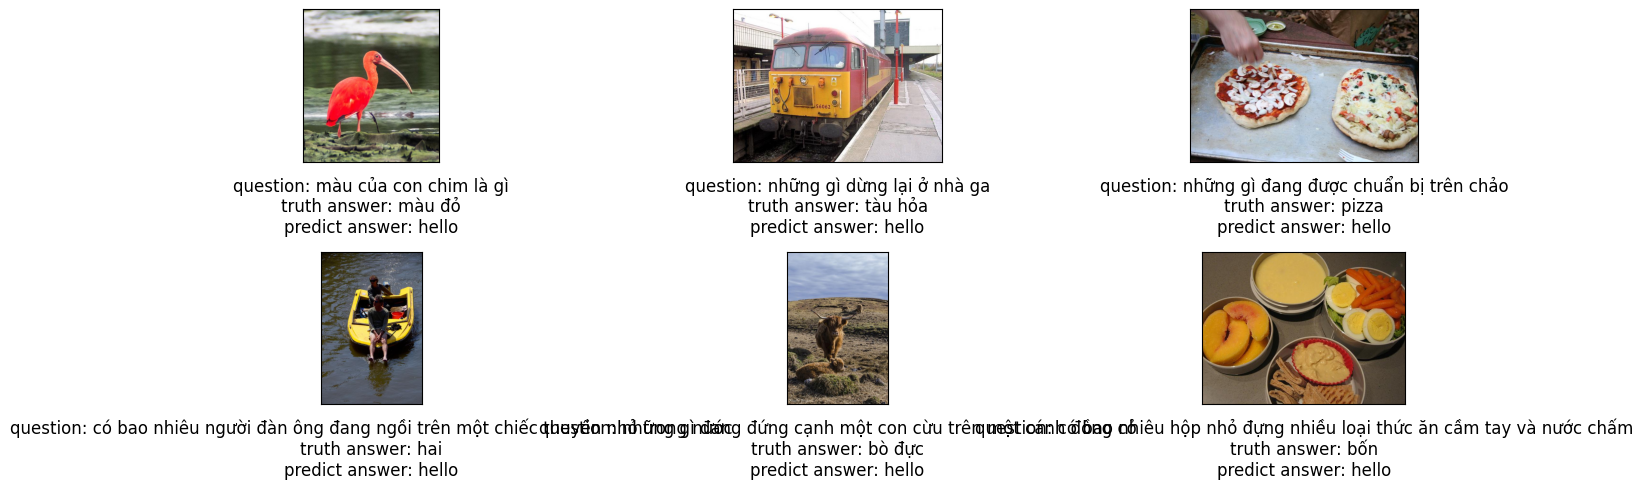

In [40]:
import os
import cv2
import matplotlib.pyplot as plt

def visual_results(loader, answer_preds, indices):
    num_images = len(indices)
    num_columns = min(3, num_images)  # Maximum 3 columns in 1 row
    num_rows = (num_images - 1) // num_columns + 1  # Calculate the number of rows

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5))
    fig.patch.set_facecolor('white')
    
    for i, idx in enumerate(indices):
        row_idx = i // num_columns
        col_idx = i % num_columns
        ax = axes[row_idx, col_idx]
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.grid(False)

        record = loader.dataset.dataset.loc[idx]
        question, answer, img_id = record['question'], record['answer'], record['img_id']

        img_path = os.path.join(config.__IMAGES__, f'{img_id}.jpg')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(img)
        qa_text = "question: {}\ntruth answer: {}\npredict answer: {}"
        cap_text = "caption: {}"
        title = qa_text.format(question, answer, answer_preds[i]) if question is not None else cap_text.format(answer)
        ax.set_title(title, y=-0.01, pad=-50 if question is not None else -15)

    # Remove any empty subplots if the number of images is not a multiple of 3
    for i in range(num_images, num_rows * num_columns):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming you have a list of indices idx_list and corresponding answer predictions answer_preds


# Example usage
# Assuming you have a list of indices idx_list and corresponding answer predictions answer_preds
your_answer_preds = ['hello', 'hello', 'hello', 'hello', 'hello', 'hello']
your_idx_list = [0, 1, 2, 3,4, 5]
visual_results(train_loader, your_answer_preds, your_idx_list)

In [46]:
import torch.nn as nn
import torch
random_tensor = torch.rand(1, 6)
multihead_attn = nn.MultiheadAttention(embed_dim=6, num_heads=2)
attn_output, attn_output_weights = multihead_attn(random_tensor, random_tensor, random_tensor)

In [54]:
# NLP Example
batch, sentence_length, embedding_dim = 20, 5, 10
embedding = torch.randn(batch, sentence_length, embedding_dim)
layer_norm = nn.LayerNorm(embedding_dim)
# Activate module
layer_norm(embedding).size()
# # Image Example
# N, C, H, W = 20, 5, 10, 10
# input = torch.randn(N, C, H, W)
# # Normalize over the last three dimensions (i.e. the channel and spatial dimensions)
# # as shown in the image below
# layer_norm = nn.LayerNorm([C, H, W])
# output = layer_norm(input)

torch.Size([20, 5, 10])

In [57]:
m = nn.Linear(20, 20)
input = torch.randn(128, 20)
output = m(input)
output

tensor([[-1.3882,  0.1817, -0.0584,  ...,  0.9805,  0.4680, -0.2142],
        [-1.0432,  0.4217, -0.7666,  ...,  1.0615,  0.6051,  0.5791],
        [ 0.5339,  0.5141, -0.4797,  ..., -1.3200,  0.3186,  0.1149],
        ...,
        [-0.3198, -0.3732,  0.0912,  ...,  0.5150, -0.5030, -0.3138],
        [ 0.0138,  0.1508,  0.2124,  ..., -0.4452, -0.1025, -0.3669],
        [-1.0353,  0.2978, -1.0986,  ..., -0.7923,  0.1105, -0.4893]],
       grad_fn=<AddmmBackward0>)

tensor([[ 0.0420,  0.4531, -0.6081,  ...,  1.5020,  0.5796,  2.3779],
        [ 0.4006,  1.2483,  0.6803,  ..., -0.3118, -2.3238,  0.2081],
        [ 0.7775, -0.4284,  0.1775,  ...,  0.6729, -0.8399, -0.2557],
        ...,
        [-1.3168,  0.1221,  0.8435,  ...,  0.9209, -0.3767,  1.7424],
        [ 0.1061, -0.1014,  0.4346,  ..., -0.8487,  0.7620, -0.1355],
        [-0.3006, -1.6200,  0.7929,  ...,  0.7832,  1.4745,  0.8054]])